In [ ]:
!pip3 install timit-utils==0.9.0

In [ ]:
!pip3 install torchaudio==0.11.0

In [ ]:
! wget https://ndownloader.figshare.com/files/10256148 

In [4]:
!unzip -q 10256148

In [5]:
import timit_utils as tu
import os
import librosa
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

In [ ]:
! wget https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3 -O sample_f.mp3
! wget https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3 -O sample_m.mp3

In [ ]:
import librosa
data, sr = librosa.load('sample_f.mp3', 16000)

In [8]:
data.shape

(24715,)

In [9]:
import IPython
IPython.display.Audio(data, rate=1600)

In [10]:
data.shape

(24715,)

In [ ]:
import librosa 
data, sr = librosa.load('sample_f.mp3', 16000)

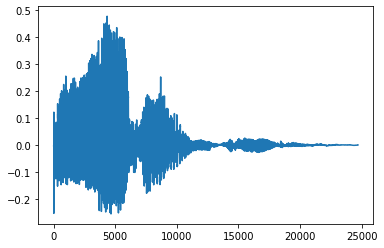

In [13]:
import matplotlib.pyplot as plt
plt.plot(data)

### **Часть 1**
Напоминание: файл *.wav -- набор амплитуд, отсчитываемых за определенные промежутки времени. Sample rate (sr) -- число отсчитываемых амплитуд в секунду, параметр качества записи. Построим график амплитуд:

In [17]:
import soundfile as sf

In [18]:
#data, sr = librosa.load(...)

In [19]:
#_sr, _data = sf.read('tmp.wav')

In [20]:
amplitudes, sample_rate = librosa.load('tmp.wav')
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")

34061 points, 1.5447165532879819 sec, sr 22050


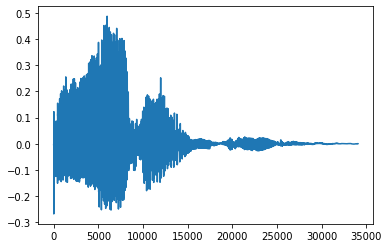

In [21]:
plt.plot(amplitudes)

В полутора секундах более 34000 точек! Работать неудобно, надо конвертировать в формат, с которым умеем работать (в изображение). Используем **оконное преобразование Фурье** чтобы понять, какие же именно компоненты преобладают в некоторый момент времени. 


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Spectrogram-19thC.png" width="640px">


Не забудем, что перед преобразование Фурье мы используем к фреймам по отдельности и потом склеиваем все в единую картину. Также следует помнить, что если использовать просто спектрограмму без перехода в мел-пространство, то мы можем сломать нашу будущую сетку слишком большими значениями. 

**Алгоритм построения мел-спектрограммы по набору частот:**
1. Разделяем вход на пересекающиеся фреймы
2. Применяем к каждому преобразование Фурье
3. Переводим полученную спектрограмму в мел-пространство

In [22]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

In [23]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [24]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [ ]:
amplitudes1, _  = librosa.load('sample_m.mp3', 16000)
amplitudes2, _  = librosa.load('sample_f.mp3',16000)

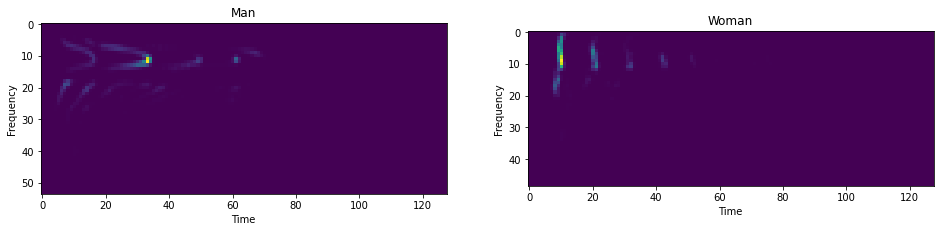

In [26]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Man"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes1).transpose())

plt.subplot(1, 2, 2)
plt.title("Woman"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes2).transpose());

In [27]:
ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

In [ ]:
import torchaudio
amplitudes, sr = torchaudio.load('sample_f.mp3')
ref2 = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, f_min=1, n_mels=128, f_max=8192)(amplitudes)

### **Часть 2**
Обучим классификатор пола по голосу

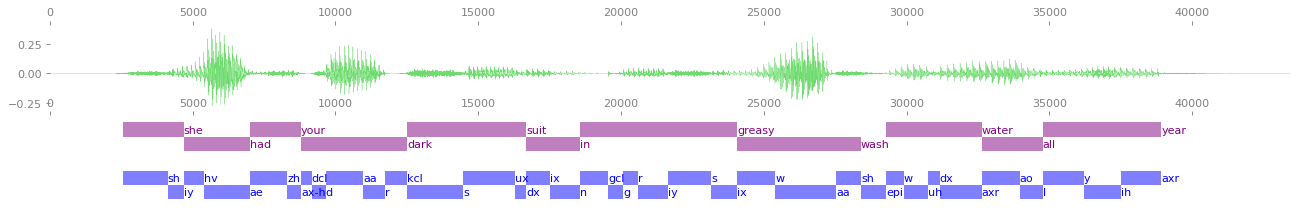

In [29]:
%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])

In [30]:
class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=False):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        # print(self.id_age_dict)
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_sex(self, id):
        return self.id_sex_dict[id]

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        if age_mode:
            for person in tqdm(people):
                try:
                    target = self.return_age(person.name)
                    for i in range(len(person.sentences)):
                        spectrograms_and_targets.append(
                            self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
                except:
                    print(person.name, target)
        else:
            for person in tqdm(people):
                target = self.return_sex(person.name)
                for i in range(len(person.sentences)):
                    spectrograms_and_targets.append(
                        self.preprocess_sample(person.sentence_by_index(i).raw_audio, target))

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 < age < 40:
            return 0.5
        if age > 40:
            return 1

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        if age_mode:
            # target = self.clasterize_by_age(target)
            target = target/80
        else:
            target = 0 if target == 'F' else 1
        # print(np.array(self.spec_to_image(np.float32(spectrogram))).shape)
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)

In [31]:
class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                t.tensor(val, dtype=t.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

In [32]:
class Model(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 1)

    def forward(self, x):
        # Apply a convolution + max pool layer for each window size
        x = torch.unsqueeze(x, 1)  # [B, C, T, F] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = torch.sigmoid(logits).view(-1)
        return probs

    def loss(self, probs, targets):
        return nn.BCELoss()(probs.float(), targets.float())

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using {device} mode')
patience = 500
best_loss = 1000
cnt = 0

using cuda mode


In [34]:
model = Model()
if device == torch.device('cuda'):
    model.cuda()
else:
    model.cpu()
model.train()

Model(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=(4, 128), stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=(5, 128), stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=384, out_features=1, bias=True)
)

In [ ]:
!unzip 1025

In [36]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)
BATCH_SIZE = 64

optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5
)

100%|██████████| 150/150 [00:18<00:00,  8.33it/s]


In [37]:
import torch as t
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(1000)):

    optimizer.zero_grad()

    input, target = trainset.next_batch(BATCH_SIZE, device=device)
    out = model(input)
    loss = model.loss(out, target)
    optimizer.step()

    if i % 50 == 0:
        model.eval()

        with torch.no_grad():
            optimizer.zero_grad()

            input, target = validset.next_batch(BATCH_SIZE, device=device)
            out = model(input)
            valid_loss = model.loss(out, target)
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            # print(out, target)
            out = [1. if tmp > 0.5 else 0 for tmp in out]
            print(f'accuracy_score:{accuracy_score(out, target)}')
            print("i {}, valid {}".format(i, valid_loss.item()))
            print("_________")

        model.train()

    if i % 50 == 0 and best_loss > valid_loss.item():
        best_loss = valid_loss.item()
        cnt = 0
    else:
        cnt += 1

    if cnt > patience:
        break
print('training finished')


<ipython-input-37-dddb9abd9e87>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-31-33a1e58bf308>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  t.tensor(val, dtype=t.float).to(device, non_blocking=True)


accuracy_score:0.640625
i 0, valid 1.8794429302215576
_________
accuracy_score:0.625
i 50, valid 2.0900421142578125
_________
accuracy_score:0.5625
i 100, valid 2.3586583137512207
_________
accuracy_score:0.703125
i 150, valid 1.2658464908599854
_________
accuracy_score:0.65625
i 200, valid 1.42848539352417
_________
accuracy_score:0.5625
i 250, valid 2.52437686920166
_________
accuracy_score:0.609375
i 300, valid 1.9941967725753784
_________
accuracy_score:0.640625
i 350, valid 1.829012155532837
_________
accuracy_score:0.703125
i 400, valid 1.5257787704467773
_________
accuracy_score:0.796875
i 450, valid 0.8499727845191956
_________
accuracy_score:0.625
i 500, valid 1.9893107414245605
_________
accuracy_score:0.71875
i 550, valid 1.5546375513076782
_________
accuracy_score:0.765625
i 600, valid 1.3784191608428955
_________
accuracy_score:0.703125
i 650, valid 1.800089955329895
_________
accuracy_score:0.625
i 700, valid 2.0543198585510254
_________
accuracy_score:0.625
i 750, valid 

In [38]:
# Code for recording audio from the browser
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython
import uuid
from google.colab import output


class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    from google.colab import output
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}" style="cursor:pointer;background-color:#EEEEEE;border-color:#E0E0E0;padding:5px 15px;font-size:14px">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb+') as f:
    f.write(b)
  return 'audio.wav'

In [47]:
model.eval()

def predict(wavfile):
    waveform, _ = librosa.load(wavfile, sr=16000)

    input = _timit_dataloader.preprocess_sample_inference(waveform)
    with torch.no_grad():
        out = model(torch.tensor(input, dtype=torch.float).to(device))
        out = out.cpu().detach().numpy()
    print(out)
    out = 'female' if out < 0.5 else 'male'
    return out

In [48]:
predict('tmp.wav')

[0.9705649]


<ipython-input-47-ca83bda2d51f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(input, dtype=torch.float).to(device))


'male'

In [49]:
# Code for recording audio from the browser
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython
import uuid
from google.colab import output


class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    from google.colab import output
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}" style="cursor:pointer;background-color:#EEEEEE;border-color:#E0E0E0;padding:5px 15px;font-size:14px">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb+') as f:
    f.write(b)
  return 'audio.wav'

In [50]:
def classify():
  print("Now recording for 3 seconds, say what you will...")
  record()
  os.system('ffmpeg -i audio.wav -ar 16000 -y audio.wav')
  print(f"Audio recording complete, guess it is {predict('audio.wav')}")

InvokeButton('Start recording', classify)

Now recording for 3 seconds, say what you will...


<IPython.core.display.Javascript object>

[0.96050864]
Audio recording complete, guess it is male


<ipython-input-47-ca83bda2d51f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(input, dtype=torch.float).to(device))


In [51]:
IPython.display.Audio('audio.wav')

In [52]:
def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

def preprocess_sample_inference(amplitudes, sr=16000, max_length=150, device='cuda'):
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    spectrogram = np.array([spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

    return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)
def predict(wavfile):
    waveform, _ = librosa.load(wavfile, sr=16000)

    input = preprocess_sample_inference(waveform)
    with torch.no_grad():
        out = model(input).cpu().detach().numpy()
    out = 1- out
    print(out)
    out = 'female' if out > 0.5 else 'male'
    return out

In [53]:
IPython.display.Audio('audio.wav')

In [54]:
predict('audio.wav')

[0.03949136]


'male'